# GMM Optimization tutorial

In this tutorial we will optimize a Gaussian Mixture Model by comparing it to a dataset of images. This showcases JAX's autodifferentiation capabilities and the possibility to connect cryoJAX to other libraries in the JAX ecosystem. For this tutorial we will use optax, so make sure to install it!

`pip install optax`

In addition, we will show how external dataloaders can be used with cryojax datasets. We will use the amazing and simple dataloader implemented by Hangzhi Guo (PhD Candidate at Penn State University):

`pip install jax-dataloader`

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import jax_dataloader as jdl

import cryojax as cx
import cryojax.simulator as cxs

from cryojax.constants import (
    get_tabulated_scattering_factor_parameters,
    convert_b_factor_to_variance,
)
from cryojax.io import read_atoms_from_pdb

/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <clas

To be able to use the jax-dataloader library we need to create a wrapper on cryoJAX's relion dataset. This can be simply done as:

In [2]:
class WrapperRelionStackDataset(jdl.Dataset):
    def __init__(self, cryojax_dataset: cx.data.RelionParticleStackDataset):
        self.cryojax_dataset = cryojax_dataset

    def __getitem__(self, index):
        return self.cryojax_dataset[index]

    def __len__(self) -> int:
        return len(self.cryojax_dataset)

# 1. Loading the data and preparing the GMM

We will use the data generated in the `../generating_data/data_generator.ipynb` tutorial. The initial GMM will be used is based on chain of GroEL in a different configuration as holo GroEL (see previous tutorial), we will refer to this initial state as apo GroEL.

## Loading the dataset

In [ ]:
relion_dataset = cx.data.RelionParticleStackDataset(
    cx.data.RelionParticleParameterFile(
        "../generating_data/dataset/relion_dataset.star", mode="r"
    ),
    path_to_relion_project="../generating_data/dataset/particles/",
    mode="r",
)

# Let's get some parameters we will need later
instrument_config = relion_dataset[0]["parameters"]["instrument_config"]
box_size = instrument_config.shape[0]
voxel_size = instrument_config.pixel_size


## Defining the initial GMM

We will follow an initial approach as before, but now we will use the scattering parameters to define the gaussian amplitudes and variances that we will use to define a GMM potential. As before, we will also instatiate a potential integrator.

In [5]:
potential_integrator = cxs.GaussianMixtureProjection(
    upsampling_factor=None,  # you can set this to compute the projection at a higher resolution
    shape=None,  # we will just use the shape of the instrument config
    use_error_functions=False,  # better quality, but slower
    n_batches=1,  # batch the computation to subsets of atoms, helps with memory management
)

In [6]:
def load_gmm_from_pdb(path_to_pdb):
    atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
        path_to_pdb,
        center=True,
        selection_string="not element H",
        loads_b_factors=True,
    )

    scattering_factor_parameters = get_tabulated_scattering_factor_parameters(
        atom_identities=atom_identities,
    )

    gaussian_amplitudes = scattering_factor_parameters["a"]
    gaussian_variances = convert_b_factor_to_variance(
        scattering_factor_parameters["b"] + b_factors[:, None]
    )
    return atom_positions, gaussian_amplitudes, gaussian_variances


path_to_apo_pdb = "../atomic_models/apo_groel.pdb"
apo_atom_pos, apo_gaussian_amp, apo_gaussian_var = load_gmm_from_pdb(path_to_apo_pdb)

# 2. Defining a loss function

We will define a gmm-to-image loss function. For this tutorial we will use a simple l2 loss, defined as

\begin{equation}
d(\textrm{GMM}, \textrm{Image}) = \min_{a > 0, b} \|a * \textrm{ForwardModel}(\textrm{GMM}) - \textrm{Image} + b \|^2.
\end{equation}

Here $a$ and $b$ correspond to a scale and offset correction when comparing the simulated image to the experimental images. The forward model is simply cryoJAX's forward model. The minimization over $a$ and $b$ can be computed analytically and its derivation is skipped for this tutorial.

The loss to be minimized will be defined on a batch of images as:
\begin{equation}
    L(\textrm{GMM}, \textrm{Images}) = \frac{1}{B} \sum_{i=1}^{B} d(\textrm{GMM}, \textrm{Image}_i),
\end{equation}

where $B$ is the batch size.

To avoid overfitting we will also apply a mask to both the computed and observed images. The mask is generated by projecting a dilated 3D mask.

In [120]:
def forward_model(
    atom_positions,
    gaussian_amplitudes,
    gaussian_variances,
    relion_stack,
    potential_integrator,
):
    potential = cxs.GaussianMixtureAtomicPotential(
        atom_positions, gaussian_amplitudes, gaussian_variances
    )

    structural_ensemble = cxs.SingleStructureEnsemble(
        potential, relion_stack["parameters"]["pose"]
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble,
        potential_integrator,
        relion_stack["parameters"]["transfer_theory"],
    )

    image_model = cxs.ContrastImageModel(
        relion_stack["parameters"]["instrument_config"], scattering_theory
    )
    return image_model.render()


def project_dillated_mask(mask_potential, mask_integrator, relion_stack):
    mask_se = cxs.SingleStructureEnsemble(
        mask_potential, relion_stack["parameters"]["pose"]
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        mask_se, mask_integrator, cxs.ContrastTransferTheory(ctf=cxs.NullCTF())
    )
    mask2d = cxs.ContrastImageModel(
        relion_stack["parameters"]["instrument_config"], scattering_theory
    ).render()

    mask2d = jnp.where(jnp.abs(mask2d) > 1e-1, 1.0, 0.0)
    return mask2d

def gmm_to_image_loss(
    atom_positions,
    gaussian_amplitudes,
    gaussian_variances,
    relion_stack,
    potential_integrator,
    mask_params
):

    mask2d = project_dillated_mask(
        *mask_params,
        relion_stack=relion_stack,
    )

    computed_image = forward_model(
        atom_positions,
        gaussian_amplitudes,
        gaussian_variances,
        relion_stack,
        potential_integrator,
    ) * mask2d
    observed_image = relion_stack["images"] * mask2d

    cc = jnp.mean(computed_image**2)
    co = jnp.mean(observed_image * computed_image)
    c = jnp.mean(computed_image)
    o = jnp.mean(observed_image)

    scale = (co - c * o) / (cc - c**2)
    offset = o - scale * c

    return jnp.sum((scale * computed_image - observed_image + offset) ** 2)


Now we can define the loss for a batch of images by simply using `equinox.filter_vmap`. In additon, we will use `equinox.filter_jit` to compile the function using just-in-time compilation (makes it run fast!).

In [72]:
@eqx.filter_jit
def gmm_to_image_batch_loss(
    atom_positions,
    gaussian_amplitudes,
    gaussian_variances,
    relion_stack,
    potential_integrator,
    mask_params,
):
    loss = eqx.filter_vmap(
        lambda x: gmm_to_image_loss(
            atom_positions,
            gaussian_amplitudes,
            gaussian_variances,
            x,
            potential_integrator,
            mask_params,
        ),
        in_axes=eqx.if_array(0),
    )(relion_stack)

    return jnp.mean(loss)

## Loading the mask

In [116]:
from cryojax.io import read_array_from_mrc

mask = read_array_from_mrc("dilated_mask.mrc")
#mask = jnp.where(jnp.abs(mask) < 1.0, 0.0, 1.0)

mask_potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(mask, voxel_size)
mask_integrator = cxs.FourierSliceExtraction()

mask_params = (mask_potential, mask_integrator)

Let's compute the loos once to confirm it works:

In [121]:
gmm_to_image_batch_loss(
    apo_atom_pos,
    apo_gaussian_amp,
    apo_gaussian_var,
    relion_dataset[0:10],
    potential_integrator,
    mask_params,
)

Array(58.633068, dtype=float32)

In addition, let's compute it for the GMM defined by the holo conformation and make sure that the loss is lower

In [122]:
path_to_holo_pdb = "../atomic_models/holo_groel.pdb"

holo_pos, holo_gaussian_amp, holo_gaussian_var = load_gmm_from_pdb(path_to_holo_pdb)

gmm_to_image_batch_loss(
    holo_pos,
    holo_gaussian_amp,
    holo_gaussian_var,
    relion_dataset[0:10],
    potential_integrator,
    mask_params,
)

Array(43.01848, dtype=float32)

# 3. Running the optimization

## Defining the dataloader

In [123]:
dataloader = jdl.DataLoader(
    WrapperRelionStackDataset(
        relion_dataset
    ),  # Can be a jdl.Dataset or pytorch or huggingface or tensorflow dataset
    backend="jax",  # Use 'jax' backend for loading data
    batch_size=100,  # Batch size
    shuffle=True,  # Shuffle the dataloader every iteration or not
    drop_last=False,  # Drop the last batch or not
)

## Initializing the optimizer

We will be using Google's optax which provides a wide range of optimization methods that can directly interact with cryoJAX. This library also provides other optimization utilities such as projections and schedulers for hyperparameters.

In [94]:
loss_fn = lambda x, y: gmm_to_image_batch_loss(
    atom_positions=x,
    gaussian_amplitudes=apo_gaussian_amp,
    gaussian_variances=apo_gaussian_var,
    relion_stack=y,
    potential_integrator=potential_integrator,
    mask_params=mask_params,
)

loss_and_grad_fn = jax.value_and_grad(loss_fn, argnums=0)

In [124]:
params = apo_atom_pos.copy()  # the quantity to be optimized

solver = optax.adabelief(learning_rate=2e-1, nesterov=True)
opt_state = solver.init(params)

n_iters = 200
progress_bar = tqdm(range(n_iters), desc="GMM Optimization", leave=True)
for _ in progress_bar:
    batch = next(iter(dataloader))
    loss, grad = loss_and_grad_fn(params, batch)
    progress_bar.set_postfix({"Loss": loss.item()})

    # Update the parameters using the optimizer
    updates, opt_state = solver.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)


GMM Optimization: 100%|██████████| 200/200 [02:45<00:00,  1.21it/s, Loss=51]  


# 4. Analysis

CryoJAX also provides utilities for analysis. In this case we will use the commonly used FSC to compare the volume generated from the Ground Truth GMM and our optimized GMM.

In [125]:
def gmm_to_volume(
    shape, voxel_size, atom_positions, gaussian_amplitudes, gaussian_variances
):
    """Convert GMM parameters to a 3D volume."""
    potential = cxs.GaussianMixtureAtomicPotential(
        atom_positions, gaussian_amplitudes, gaussian_variances
    )
    return potential.as_real_voxel_grid(shape, voxel_size)


apo_volume = gmm_to_volume(
    shape=(box_size, box_size, box_size),
    voxel_size=voxel_size,
    atom_positions=apo_atom_pos,
    gaussian_amplitudes=apo_gaussian_amp,
    gaussian_variances=apo_gaussian_var,
)

holo_volume = gmm_to_volume(
    shape=(box_size, box_size, box_size),
    voxel_size=voxel_size,
    atom_positions=holo_pos,
    gaussian_amplitudes=holo_gaussian_amp,
    gaussian_variances=holo_gaussian_var,
)

opt_volume = gmm_to_volume(
    shape=(box_size, box_size, box_size),
    voxel_size=voxel_size,
    atom_positions=params,
    gaussian_amplitudes=apo_gaussian_amp,
    gaussian_variances=apo_gaussian_var,
)

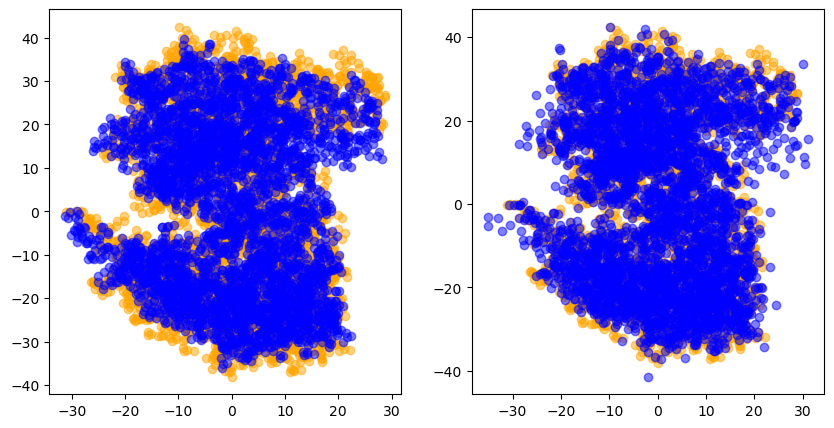

In [126]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(holo_pos[:, 0], holo_pos[:, 1], alpha=0.5, color="orange")
ax[0].scatter(apo_atom_pos[:, 0], apo_atom_pos[:, 1], alpha=0.5, color="blue")


ax[1].scatter(holo_pos[:, 0], holo_pos[:, 1], alpha=0.5, color="orange")
ax[1].scatter(params[:, 0], params[:, 1], alpha=0.5, color="blue")


Text(0.5, 1.0, 'Optimized Volume')

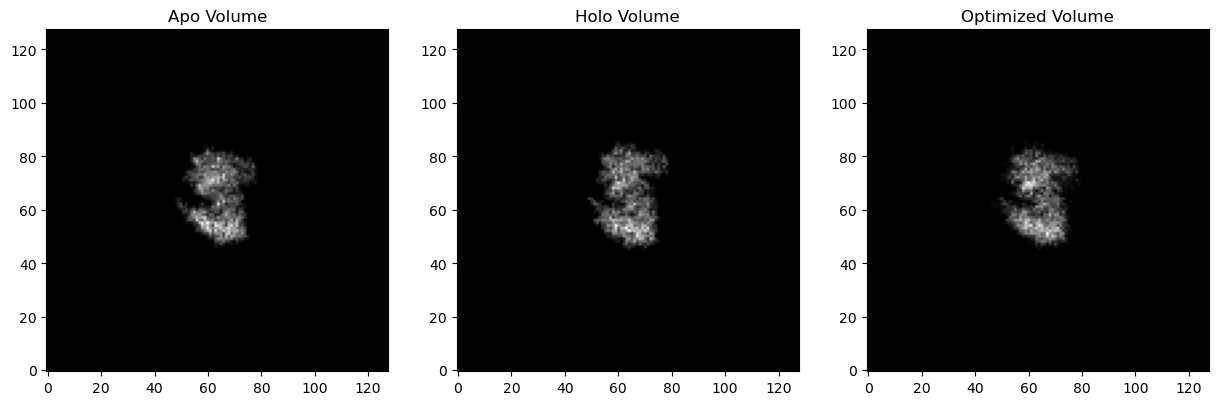

In [127]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(apo_volume.sum(0), cmap="gray", origin="lower")
ax[0].set_title("Apo Volume")
ax[1].imshow(holo_volume.sum(0), cmap="gray", origin="lower")
ax[1].set_title("Holo Volume")
ax[2].imshow(opt_volume.sum(0), cmap="gray", origin="lower")
ax[2].set_title("Optimized Volume")

In [128]:
holo_volume_fft = cx.image.rfftn(holo_volume)
opt_volume_fft = cx.image.rfftn(opt_volume)
apo_volume_fft = cx.image.rfftn(apo_volume)

radial_frequency_grid = cx.coordinates.make_radial_frequency_grid(
    holo_volume.shape, voxel_size, outputs_rfftfreqs=True
)


initial_fsc_curve, frequency_bins, _ = cx.image.compute_fourier_shell_correlation(
    holo_volume_fft, apo_volume_fft, radial_frequency_grid, voxel_size
)

optimized_fsc_curve, _, _ = cx.image.compute_fourier_shell_correlation(
    holo_volume_fft, opt_volume_fft, radial_frequency_grid, voxel_size
)

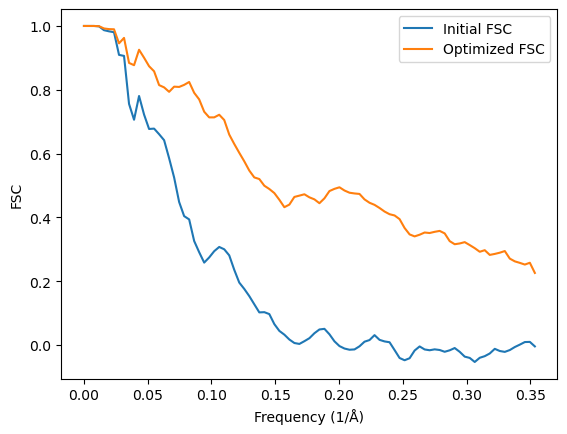

In [129]:
plt.plot(frequency_bins, initial_fsc_curve, label="Initial FSC")
plt.plot(frequency_bins, optimized_fsc_curve, label="Optimized FSC")
plt.xlabel("Frequency (1/Å)")
plt.ylabel("FSC")
plt.legend()